In [5]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


In [6]:
img=cv2.imread('lena.png',cv2.IMREAD_GRAYSCALE)/255

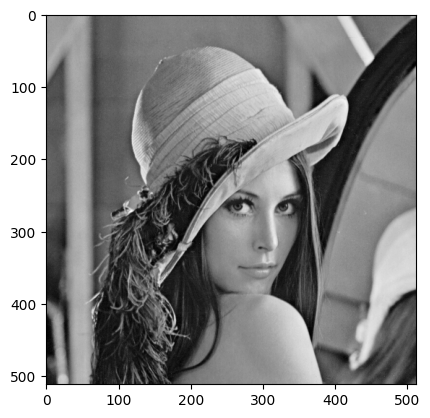

(512, 512)

In [7]:
plt.imshow(img,cmap='gray')
plt.show()
img.shape

In [8]:
class conv:
  def __init__(self, n_filters, filter_size):
    self.n_filters=n_filters
    self.filter_size= filter_size
    self.conv_filter=np.random.randn(n_filters,filter_size,filter_size)/(filter_size*filter_size)
#generator fn
  def image_region(self,image):
    h,w=image.shape
    self.image=image
    for j in range(h-self.filter_size +1):
      for k in range(w-self.filter_size +1):
        image_patch=image[j: (j+self.filter_size),k :(k+self.filter_size)]
        yield image_patch,j,k

  def forward_prop(self,image):
    h,w=image.shape
    conv_out=np.zeros((h-self.filter_size +1, w-self.filter_size+1, self.n_filters))
    for image_patch,i,j in self.image_region(image):
      conv_out[i,j]=np.sum(image_patch*self.conv_filter , axis=(1,2))
    return conv_out

#dl_dout output of maxpool
  def back_prop(self,dl_dout, lr):
    dl_df_params=np.zeros(self.conv_filter.shape)
    for image_patch,i,j in self.image_region(self.image):
      for k in range(self.n_filters):
        dl_df_params[k]+=image_patch*dl_dout[i,j,k]

      #filter params update
    self.conv_filter-=lr*dl_df_params
    return dl_df_params






In [9]:
con=conv(18,7) #18 no. of filters, 7x7 size of filters
out=con.forward_prop(img)
out.shape

(506, 506, 18)

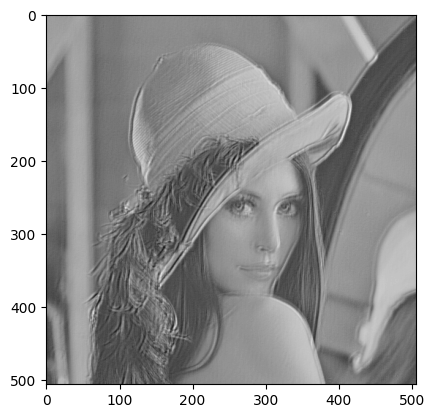

In [10]:
plt.imshow(out[:,:,17],cmap='gray')
plt.show()

In [11]:
class max_pool:
  def __init__(self,filter_size):
    self.filter_size=filter_size

  def image_region(self,image):
    newh=image.shape[0] // self.filter_size
    neww=image.shape[1] // self.filter_size
    self.image=image

    for i in range(newh):
      for j in range(neww):
        image_patch=image[(i*self.filter_size): (i*self.filter_size + self.filter_size), (j*self.filter_size): (j* self.filter_size+ self.filter_size)]
        yield image_patch,i,j

  def forward_prop(self,image):
    h,w,n_filters=image.shape
    o=np.zeros((h//self.filter_size,w// self.filter_size,n_filters))

    for image_patch,i,j in self.image_region(image):
      o[i,j]=np.amax(image_patch,axis=(0,1))
    return o
#dl_dout: softmax o/p
  def back_prop(self,dl_dout):
    dl_dmax_pool=np.zeros(self.image.shape)
    for image_patch ,i,j in self.image_region(self.image):
      h,w,n_filters=image_patch.shape
      max_val=np.amax(image_patch,axis=(0,1))

      for i1 in range(h):
        for j1 in range(w):
          for k1 in range(n_filters):
            if image_patch[i1,j1,k1]==max_val[k1]:
              dl_dmax_pool[i*self.filter_size+i1,j*self.filter_size+j1,k1]=dl_dout[i,j,k1]
      return dl_dmax_pool

In [12]:
con2=max_pool(4)
out2=con2.forward_prop(out)
out2.shape

(126, 126, 18)

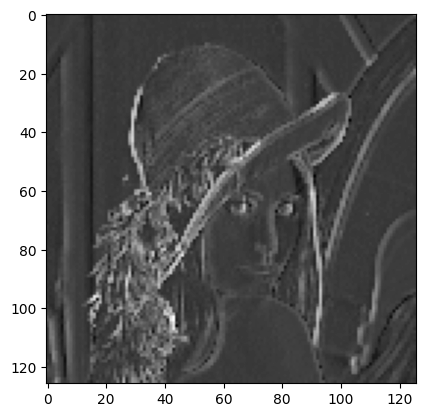

In [13]:
plt.imshow(out2[:,:,13],cmap='gray')
plt.show()

In [14]:
class softmax:
  def __init__(self,inp_node,softmax_node):
    self.w=np.random.randn(inp_node,softmax_node)/inp_node
    self.b=np.zeros(softmax_node)

  def forward_prop(self,image):
#flattening, multiplying w,b  and generating c o/p layer
     self.orig_im_shape=image.shape #used in backprop
     image_modified=image.flatten()
     self.modified_input=image_modified   #to be used in backdrop
     out_val=np.dot(image_modified,self.w)+self.b
     self.out=out_val
     exp_out=np.exp(out_val)
     return exp_out/np.sum(exp_out,axis=0)

  def back_prop(self,dl_dout,lr):
    for i,grad in enumerate(dl_dout):
      if grad==0:
        continue

      trans_eq=np.exp(self.out)
      s_tot=np.sum(trans_eq)

      #gradients wrt out (z)
      dy_dz=-trans_eq[i]*trans_eq/(s_tot **2)
      dy_dz[i]= trans_eq[i]*(s_tot-trans_eq[i])/(s_tot**2)

      #gradients of tot against w/b/inp
      dz_dw=self.modified_input
      dz_db=1
      dz_d_inp=self.w

      #gradients of loss against tot
      dl_dz=grad*dy_dz

      #gradients of loss against w/b/inp
      dl_dw=dz_dw[np.newaxis].T @ dl_dz[np.newaxis]
      dl_db=dl_dz*dz_db
      dl_d_inp=dz_d_inp @ dl_dz

    self.w -=lr*dl_dw
    self.b -=lr*dl_db

    return dl_d_inp.reshape(self.orig_im_shape)


In [16]:
con3=softmax(126*126*18,10)
out3=con3.forward_prop(out2)
print(out3)

[0.10001622 0.10000965 0.10000906 0.10000136 0.09998583 0.10000629
 0.10000039 0.09998324 0.09999897 0.09998899]


In [17]:
from keras.datasets import mnist

In [18]:
(x_train, y_train),(x_test,y_test)=mnist.load_data()


11490434/11490434 [==============================] - 1s 0us/step


In [33]:
train_img=x_train[:1500]
train_labels=y_train[:1500]
test_images=x_test[:1500]
test_labels=y_test[:1500]

convo=conv(8,3)
pool=max_pool(2)
softmax=softmax(13*13*8,10)



In [34]:
def cnn_forward_prop(image,label):
  out_p=convo.forward_prop((image /255)-0.5)
  out_p=pool.forward_prop(out_p)
  out_p=softmax.forward_prop(out_p)

  #cross-entropy loss, accuracy
  ce_loss=-np.log(out_p[label])
  acc_eval=1 if np.argmax(out_p)==label else 0

  return out_p,ce_loss,acc_eval


In [35]:
def training_cnn(image,label,lr=0.05):

  #forward
  out,loss,acc=cnn_forward_prop(image,label)

  #cal initial grad
  g=np.zeros(10)
  g[label]=-1/out[label]

  #backprop
  g_back=softmax.back_prop(g,lr)
  g_back=pool.back_prop(g_back)
  g_back=convo.back_prop(g_back,lr)

  return loss,acc


In [40]:
for epoch in range(2):
  print('epoch %d ---> '%(epoch+1))

  #shuffle training data
  shuffle_data=np.random.permutation(len(train_img))
  train_img=train_img[shuffle_data]
  train_labels=train_labels[shuffle_data]

  #training cnn
  loss=0
  n_correct=0
  for i,(im,label) in enumerate(zip(train_img,train_labels)):
    if i%100==0:
      print('%d steps out of 100 steps: Average loss %.3f and accuracy : %d%%' %(i+1,loss/100,n_correct))
      loss=0
      n_correct=0

    l1,accu=training_cnn(im,label)
    loss+=l1
    n_correct+=accu

#testing cnn
print('**TESTING PHASE')
loss=0
n_correct=0
for im,label in zip(test_images,test_labels):
   _,l1,accu=cnn_forward_prop(im,label)
   loss+=l1
   n_correct+=accu
n_tests=len(test_images)
print('Test Loss :',loss/n_tests)
print('Test accuracy:',n_correct/n_tests)




epoch 1 ---> 
1 steps out of 100 steps: Average loss 0.000 and accuracy : 0%
101 steps out of 100 steps: Average loss 0.603 and accuracy : 90%
201 steps out of 100 steps: Average loss 0.549 and accuracy : 92%
301 steps out of 100 steps: Average loss 0.657 and accuracy : 84%
401 steps out of 100 steps: Average loss 0.624 and accuracy : 84%
501 steps out of 100 steps: Average loss 0.656 and accuracy : 84%
601 steps out of 100 steps: Average loss 0.599 and accuracy : 88%
701 steps out of 100 steps: Average loss 0.619 and accuracy : 84%
801 steps out of 100 steps: Average loss 0.666 and accuracy : 84%
901 steps out of 100 steps: Average loss 0.629 and accuracy : 86%
1001 steps out of 100 steps: Average loss 0.690 and accuracy : 83%
1101 steps out of 100 steps: Average loss 0.501 and accuracy : 88%
1201 steps out of 100 steps: Average loss 0.593 and accuracy : 84%
1301 steps out of 100 steps: Average loss 0.499 and accuracy : 88%
1401 steps out of 100 steps: Average loss 0.636 and accuracy 